### Compute the RAScore of the molecules

In [2]:
from RAscore import RAscore_XGB, RAscore_NN

2022-01-24 02:58:38.306825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
rascorer = RAscore_NN.RAScorerNN()

2022-01-24 02:58:40.187186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-24 02:58:40.284492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 02:58:40.285740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M2200 computeCapability: 5.2
coreClock: 1.036GHz coreCount: 8 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 82.08GiB/s
2022-01-24 02:58:40.285842: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-24 02:58:40.303965: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-24 02:58:40.304158: I tensorflow/stream_executor/platform/default

In [4]:
mol = 'COCOCO'
rascorer.predict(mol)

2022-01-24 02:58:41.127211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-24 02:58:41.147827: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz


0.99948967

In [5]:
# open the smiles lists
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from rdkit import Chem
# from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
# from gym_PGFS.valuation.plot_utils import plot_medians, process_output_into_dataframe

In [6]:
run_dirs = {'./data/run_B_long': 'CHEMBL3888429', 
            './data/run_A_long': 'CHEMBL1909140', 
            './data/run_C_long': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df

    

108000
[0 1 2 3 4 5]
Picking 5
118800
[0 1 2 3 4 5]
Picking 5


/tmp/ipykernel_9567/3835550847.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])


118800
[0 1 2 3 4 5]
Picking 5


In [7]:
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]

    rascore_lstm = lstm.smiles.apply(rascorer.predict)

    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]

    rascore_pgfs = pgfs.smiles.apply(rascorer.predict)

    # now make a boxplot
    lstms[dataset_name] = rascore_lstm.to_numpy()
    pgfss[dataset_name] = rascore_pgfs.to_numpy()

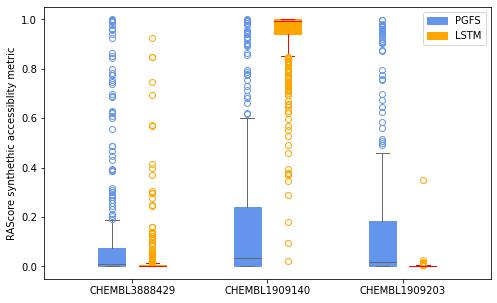

In [8]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
plt.ylabel(f"RAScore synthethic accessiblity metric")
# plt.xlabel("")

rng = np.arange(len(pgfs_out.keys()))
c, c_highlight = 'cornflowerblue', 'dimgrey'
pgfs_boxes = ax.boxplot(pgfss.values(), patch_artist=True, positions=rng-0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))
c, c_highlight = 'orange', 'red'
lstm_boxes = ax.boxplot(lstms.values(), patch_artist=True, positions=rng+0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))

ax.legend([pgfs_boxes["boxes"][0], lstm_boxes["boxes"][0]],
          ['PGFS', 'LSTM'],
          loc='upper right')

plt.xticks(rng, pgfss.keys())
plt.show()

<b>Sampling some molecules from LSTM and PGFS on CHEMBL1909203:</b>
<b>LSTM:</b>
CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCCCCC#CC#CSC#CSC[n+]2ccccc2)cc1
0.0003271103


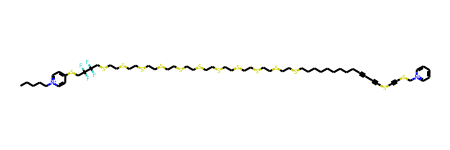

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCCC#CC#CSC#CSCCSCCSC[n+]2ccccc2)cc1
0.0027134418


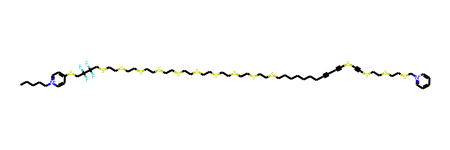

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCC#CC#CSC#CSCCCCSCCC[n+]2ccccc2)cc1
0.00010568562


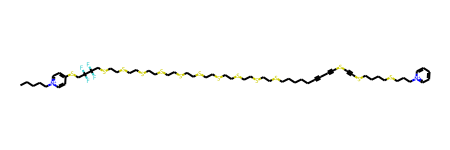

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCC#CC#CSC#CSCCCCCSCCC[n+]2ccccc2)cc1
0.0016272068


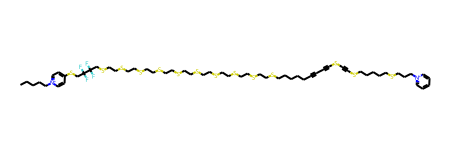

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCCCCC#CC#CSC#CSCCCSC[n+]2ccccc2)cc1
9.7046606e-05


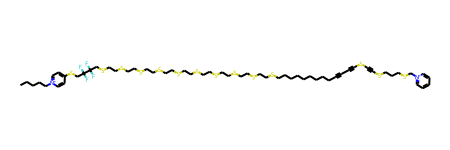

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCCCC#CC#CSC#CSCC[n+]2ccccc2)cc1
0.0027372837


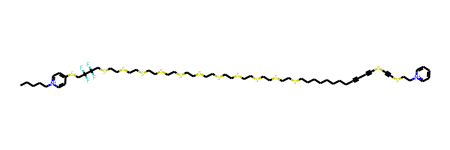

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCC#CC#CC#CSC#CSCCSC[n+]2ccccc2)cc1
0.0024793446


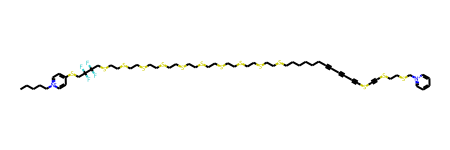

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCC#CC#CSC#CSCCCCSCCSC[n+]2ccccc2)cc1
0.00037047267


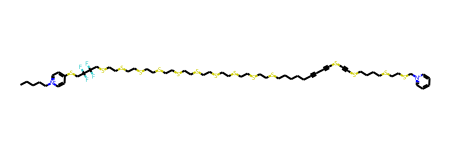

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCSCCCCCC#CC#CSC#CSCC[n+]2ccccc2)cc1
0.00033158064


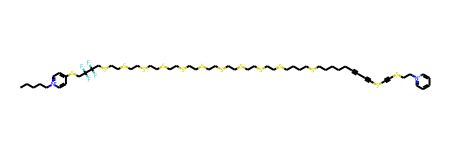

CCCCC[n+]1ccc(SCC(F)(F)C(F)(F)CSCCSCCSCCSCCSCCSCCSCCSCCSCCSCCCCCCCC#CC#CSC#CSCCCCC[n+]2ccccc2)cc1
0.00028911233


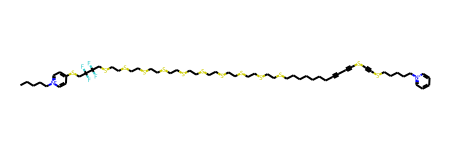

<b>PGFS:</b>
CCCCCCCCCC#CCOC(O)(C(=O)N(C)C(C)C#N)C(CCCCC)c1nc2cc(C(F)(F)F)ccc2s1
0.047935367


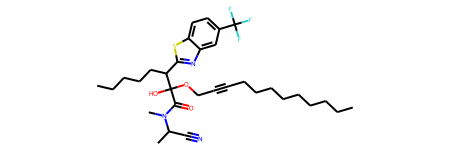

CCCCCCCCC(C)C(=O)C(C)(Br)C(CC)(CCCCCC)C(=O)C1(NC(=O)C(CC2CCCC2)n2c3c4c(c2C3)CC4)CNC1=O
0.37401152


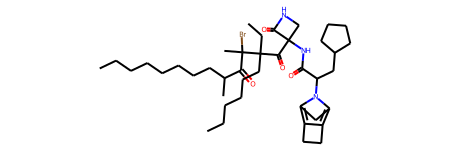

CCCCCCCCC(C)C(C(=O)OC1Cc2nn(CCC3CCCCC3)c(C(C)(CCCCCC)NC(=O)C3C4CCCCCC43)c21)C(=O)C(N)CC1CCCCC1
0.010841399


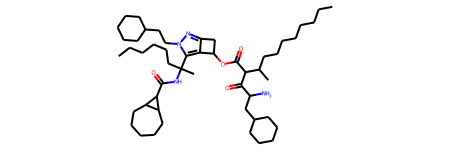

CCCCCCCCCCN1CCC(CC2C(=O)N(CCCn3ncc4cc(N(C)C)ccc4c3=O)C(=O)C2C(=O)C(C)(CCCCCC)n2c(C(C)C)ccc2C(C)C)CC1
0.42082366


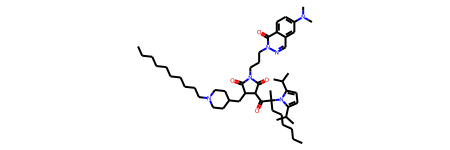

CCCCCCCCCC#CCOC(O)(CCn1nc(C(C)(C)C)cc1C(C)(C)C)C(=O)C(CC)(CC)CCC(CCC)C(=O)CC(C)CCCCCCCC
0.13491997


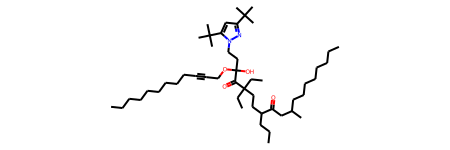

CCCCCCCCCCCCc1nnn(CC2CC(C(C)(C)C)=NO2)c1C1(n2c(C(Br)C(C)C3CCCCC3)nc3cc(OC)c(OC)cc3c2=O)CC1
0.013969928


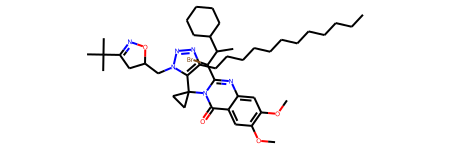

CCCCCCCCCCCC(C(=O)C(CC)(CC)CCCCCC)C1(COC(=O)c2c(C)nn(CC(C)CC(=O)C(CC)(CC)CCCCCC)c2Oc2cc(C)nc(C(C)(C)C)n2)CC1
0.0004030466


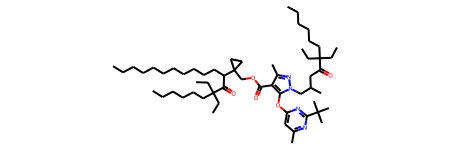

C#CCCCCCNC(CC(C)CCCCCCCC)C(C)(CCCCCCCCCCCC(C)n1cnc2ccc(N(C)C)cc2c1=O)C(=O)C(C)(N)CCCCCC
0.017094046


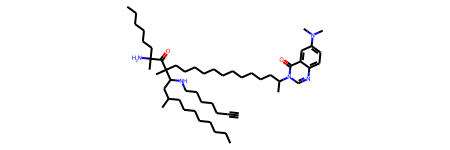

C#CCCCCCNC(CC(C(=O)c1cc(C)sc1C)C(=O)C(CC)C(=O)C(C)C)C(C)(C=O)CCCCCCCCCC
0.019525588


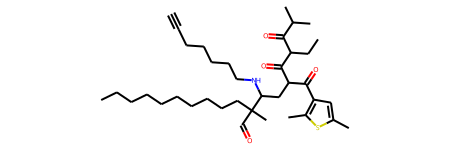

CCCCCCCCC(Cl)(C(=O)NO)C(=O)C(CC)(CCCCCC)C(=O)C(C)(N)CCCCCC
0.03601405


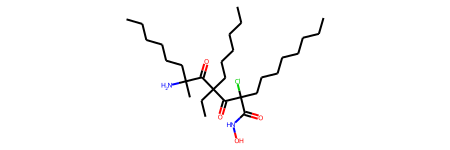

In [9]:
# visualize some molecules
current_set = 'CHEMBL1909203'#'CHEMBL1909140'
print(f'<b>Sampling some molecules from LSTM and PGFS on {current_set}:</b>')
print('<b>LSTM:</b>')
lstm = lstm_out[current_set]
last_lstm = lstm.epoch.max()
lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)].smiles.sample(10)
for smi in lstm.tolist():
    print(smi)
    print(rascorer.predict(smi))
    display(Chem.MolFromSmiles(smi))
# visualize some molecules
print('<b>PGFS:</b>')
pgfs = pgfs_out[current_set]
last_pgfs = pgfs.epoch.max()
pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)].smiles.sample(10)
for smi in pgfs.tolist():
    print(smi)
    print(rascorer.predict(smi))
    display(Chem.MolFromSmiles(smi))

## Let's try plotting the DCS comparison plot from the other notebook, but only using the scores from the top 50% best RAScoring molecules:

In [8]:
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]

    rascore_lstm = lstm.smiles.apply(rascorer.predict)
    # now compute the median score, and leave only the compounds, that are above that
    lstm_median_rascore = rascore_lstm.quantile(0.8)
    lstm = lstm[rascore_lstm>lstm_median_rascore]
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    rascore_pgfs = pgfs.smiles.apply(rascorer.predict)
    # now compute the median score, and leave only the compounds, that are above that
    pgfs_median_rascore = rascore_pgfs.quantile(0.8)
    pgfs = pgfs[rascore_pgfs>pgfs_median_rascore]
    
    # now make a boxplot
    lstms[dataset_name] = lstm.value.to_numpy()
    pgfss[dataset_name] = pgfs.value.to_numpy()
    


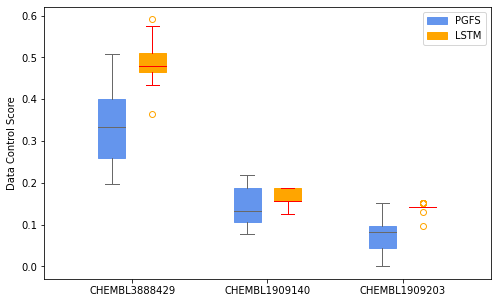

In [9]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
plt.ylabel(f"Data Control Score")
# plt.xlabel("")

rng = np.arange(len(pgfs_out.keys()))
c, c_highlight = 'cornflowerblue', 'dimgrey'
pgfs_boxes = ax.boxplot(pgfss.values(), patch_artist=True, positions=rng-0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))
c, c_highlight = 'orange', 'red'
lstm_boxes = ax.boxplot(lstms.values(), patch_artist=True, positions=rng+0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))

ax.legend([pgfs_boxes["boxes"][0], lstm_boxes["boxes"][0]],
          ['PGFS', 'LSTM'],
          loc='upper right')

plt.xticks(rng, pgfss.keys())
plt.show()